# 并行计算

**蒙特卡洛算法**

Black-Stcholes-Merton SDE
$$
dS_{t}=rS_{t}dt+\sigma S_{t}dZ_{t}
$$

欧式看涨期权的蒙特卡洛估算函数
$$
C_{0}=e^{-rT}\frac{1}{T}\sum max(S_{T}(i)-K,0)
$$



In [1]:
def bsm_mcs_valuation(strike):
    import numpy as np
    S0=100.;T=1.0;r=0.05;vola=0.2
    M=50;I=20000
    dt=T/M
    rand=np.random.standard_normal((M+1,I))
    S=np.zeros((M+1,I));S[0]=S0
    for t in range(1,M+1):
        S[t]=S[t-1]*np.exp((r-0.5*vola**2)*dt+vola*np.sqrt(dt)*rand[t])
    value=(np.exp(-r*T)*np.sum(np.maximum(S[-1]-strike,0))/I)
    
    return value

In [5]:
#顺序化计算

def seq_value(n):
    import numpy as np
    strikes=np.linspace(80,120,n)
    option_values=[]
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes,option_values
n=100
strikes,option_values=seq_value(100)

Text(0, 0.5, 'European call option values')

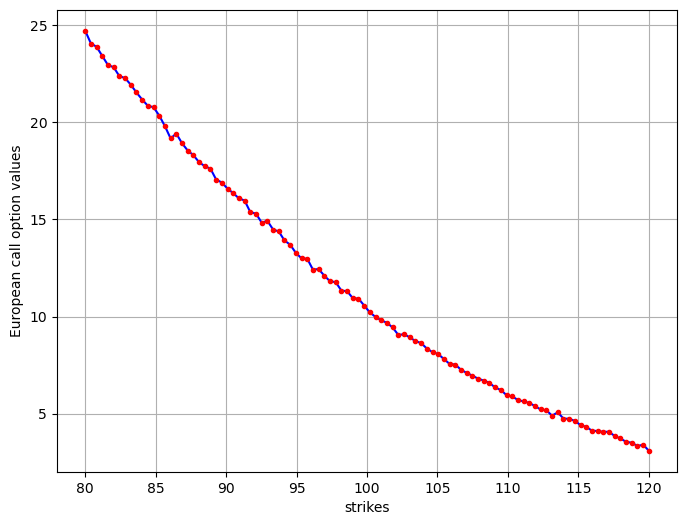

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(strikes,option_values,'b')
plt.plot(strikes,option_values,'r.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')

**多处理**

In [21]:
import multiprocessing as mp
import math
import numpy as np
def simulate_geometric_brownian_motion(p):
    M,I=p
    S0=100;r=0.05;sigma=0.2;T=1.0
    dt=T/M
    paths=np.zeros((M+1,I))
    paths[0]=S0
    for t in range(1,M+1):
        paths[t]=paths[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*np.random.standard_normal(I))
    return paths

paths=simulate_geometric_brownian_motion((5,2))
paths.shape

(6, 2)

In [ ]:
I=10000#paths的数量
M=100#时间步数
t=100#模拟次数

from time import time
times=[]
for w in range(1,17):
    t0=time()
    pool=mp.Pool(processes=w)
    result=pool.map(simulate_geometric_brownian_motion,t*[(M,I),])
    times.append(time()-t0)
    
plt.plot(range(l,17), times) 
plt.plot(range(l,17), times, 'ro') 
plt.grid(True) 
plt.xlabel('number of processes') 
plt.ylabel('time in seconds') 
plt. title('%d onte Carlo simulations' % t)

# 二项式期权定价方法


从当天到期权到期日的时间间隔被分为通常等距的子间隔$\delta t$。如果时间s的指数水平为$S_{t}$,则$t=s+\delta t$时的指数水平为$S_{t}=S_{t}*m$,其中m是从{u,d}中随机选取$（0<d<e^{r\delta t},u=\frac{1}{d}）$.r是一个常数-无风险利率。风险中立的上涨概率为$q=\frac{e^{r\delta t-d}}{u-d}$

In [2]:
from math import exp,sqrt
import numpy as np
import pandas as pd


S0=100
T=1
r=0.05
vola=0.2

M=1000
dt=T/M
df=exp(-r*dt)

u=exp(vola*sqrt(dt))#上升时期
d=1/u #下降时期
q=(exp(r*dt)-d)/(u-d)#风险上升概率




In [3]:
def binomial_py(strike):
    S=np.zeros((M+1,M+1),dtype=np.float64)
    S[0,0]=S0
    z1=0
    for j in xrange(1,M+1,1):
        z1=z1+1
        for i in xrange(z1+1):
            S[i,j]=S[0,0]*(u**j)*(d**(i*2))
    
    iv=np.zeros((M+1,M+1),dtype=np.float64)
    z2=0
    for j in xrange(0,M+1,1):
        for i in xrange(z2+1):
            iv=[i,j]=max(S[i,j]-strike,0)
        z2+=1
    
    pv=np.zeros((M+1,M+1),dtype=np.float64)
    pv[:,M]=iv[:,M]
    z3=M+1
    for j in xrange(M-1,-1,-1):
        ze3-=1
        for i in xrange(z3):
            pv[i,j]=(q*pv[i,j+1]+(1-q)*pv[i+1,j+1]*df)
    return pv[0,0]



In [5]:
def binomial_np(strike):
    mu=np.arange(M+1)
    mu=np.resize(mu,(M+1,M+1))
    md=np.transpose(mu)
    mu=u**(mu-md)
    md=d**md
    S=S0*mu*md
    
    pv=np.maximum(S-strike,0)
    z=0
    for t in range(M-1,-1,-1):
        pv[0:M-z,t]=(q*pv[0:M-z,t+1]+(1-q)*pv[1:M,pv[1:M-z+1,t+1]])*df
        z+=1
    return pv[0,0]

In [6]:
M=4
mu=np.arange(M+1)
mu

array([0, 1, 2, 3, 4])

In [7]:
mu=np.resize(mu,(M+1,M+1))
mu

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [8]:
md=np.transpose(mu)
md

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [9]:
import numba as nb
binomial_nb=nb.jit(binomial_py)

In [14]:
from numbapro.cudalib import curand

def get_randoms(x,y):
    rand=np.random.standard_normal((x,y))
    return rand

ModuleNotFoundError: No module named 'numbapro'